In [1]:
! nvidia-smi

Mon Apr 18 09:57:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# access my dataset
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
! pip3 install transformers==4.12.0  # newer version may fail
! pip3 show transformers

     |████████████████████████████████| 3.1 MB 24.9 MB/s 
     |████████████████████████████████| 895 kB 46.4 MB/s 
     |████████████████████████████████| 596 kB 66.1 MB/s 
     |████████████████████████████████| 77 kB 6.5 MB/s 
     |████████████████████████████████| 3.3 MB 63.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Name: transformers
Version: 4.12.0
Summary: State-of-the-art Natural Language Processing for TensorFlow 2.0 and PyTorch
Home-page: https://github.com/huggingface/transformers
Author: Thomas Wolf, Lysandre Debut, Victor Sanh, Julien Chaumond, Sam Shleifer, Patrick von Platen, Sylvain Gugger, Suraj Patil, Stas Bekman, Google AI Language Team Authors, Open AI team Authors, Facebook AI Authors, Carnegie Mellon University Authors
Author-email: thomas@huggingface.co
License: Apache
Location: /usr/local/lib/python3.7/dist-packages
Requires: sacremoses, numpy, hugg

In [4]:
! mkdir data_description
! cp /content/gdrive/MyDrive/Tbrain/data_description/*.csv /content/data_description/
! unzip /content/gdrive/MyDrive/Tbrain/little_public_training_data.zip > train_data_unzip.log
! unzip /content/gdrive/MyDrive/Tbrain/little_public_testing_data.zip > test_data_unzip.log

In [5]:
! cp -r /content/gdrive/MyDrive/Tbrain/seq2seq/my-model-epoch20_processor ./
! unzip /content/gdrive/MyDrive/Tbrain/seq2seq/my-model-epoch20.zip > my-model-epoch20.log

In [6]:
import os
import torch
import random
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
from transformers import TrOCRProcessor, VisionEncoderDecoderConfig, VisionEncoderDecoderModel, AdamW, get_scheduler
from torch.nn.utils.rnn import pad_sequence
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode, hflip, vflip
from torch.utils.data import DataLoader, Dataset, ConcatDataset, random_split
os.environ['WANDB_CONSOLE'] = 'off'  # prevent AssertionError: can only test a child process
random.seed(2021)


class MyDataset(Dataset):
    def __init__(self, images_dir, captions_file, tokenizer, transform=None):
        self.images_dir = images_dir
        self.captions_df = pd.read_csv(captions_file)
        self.tokenizer = tokenizer
        self.transform = transform
        # get image and caption columns
        self.images = self.captions_df["new_filename"].tolist()
        self.captions = self.captions_df["label"].str.join(" ").tolist()

    def __len__(self):
        return len(self.captions_df)

    def __getitem__(self, index):
        caption = self.captions[index]
        try:
            image_name = self.images[index] + '.jpg'
            image = Image.open(os.path.join(self.images_dir, image_name)).convert("RGB")
        except:
            image_name = self.images[index] + '.JPG'
            image = Image.open(os.path.join(self.images_dir, image_name)).convert("RGB")

        if self.transform is not None:
            transform_image = self.transform(image)
        with self.tokenizer.as_target_processor():
            caption_ids = self.tokenizer(caption, return_tensors="pt").input_ids  # caption僅1筆數據時，padding=True沒有作用。

        return image, transform_image, caption_ids


class MyCollate:
    """ To handle batch text input padding problem """
    def __init__(self, tokenizer, pad_value: int):
        self.pad_value = pad_value
        self.tokenizer = tokenizer

    def __call__(self, batch):
        val_inputs_ls = [item[0] for item in batch]
        val_inputs_ls = self.tokenizer(val_inputs_ls, return_tensors="pt").pixel_values
        transform_images = [item[1].unsqueeze(0) for item in batch]
        transform_images = torch.cat(transform_images, dim=0)
        texts = [item[2].transpose(1, 0) for item in batch]
        texts = pad_sequence(texts, batch_first=True, padding_value=self.pad_value).squeeze(2)
        texts = texts.to(torch.long)
        texts_in = texts[:, :-1]  # decoder input
        texts_target = texts[:, 1:]  # decoder target, compute loss with decoder output.
        # print(texts_in)
        # print(texts_target)
        # print('*'*50)
        texts_mask = torch.logical_not(texts_in == self.pad_value, out=torch.empty(texts_in.size(), dtype=torch.float))
        # print(texts_mask)
        return val_inputs_ls, transform_images, texts_mask, texts_in, texts_target


class MyFlipTransform:
    """  With probability p, flip vertical and horizontal at the same time. """

    def __init__(self, p: float):
        """ :param p, is float number from 0. to 1. """
        self.p = p

    def __call__(self, x):
        if random.uniform(0., 1.) < self.p:
            x = hflip(x)
            x = vflip(x)
        return x


def get_loader(dataset, tokenizer, batch_size=16, num_workers=2, shuffle=True, pin_memory=True):
    pad_value = tokenizer.tokenizer.pad_token_id  # in this case, pad_idx is 1
    loader = DataLoader(dataset=dataset, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle,
                pin_memory=pin_memory, collate_fn=MyCollate(pad_value=pad_value, tokenizer=tokenizer))
    return loader, dataset


def levenshtein(s, t):
    """ From Wikipedia article; Iterative with two matrix rows. """
    if s == t:
        return 0
    elif len(s) == 0:
        return len(t)
    elif len(t) == 0:
        return len(s)
    v0 = [None] * (len(t) + 1)
    v1 = [None] * (len(t) + 1)
    for i in range(len(v0)):
        v0[i] = i
    for i in range(len(s)):
        v1[0] = i + 1
        for j in range(len(t)):
            cost = 0 if s[i] == t[j] else 1
            v1[j + 1] = min(v1[j] + 1, v0[j + 1] + 1, v0[j] + cost)
        for j in range(len(v0)):
            v0[j] = v1[j]
    return v1[len(t)]


def my_metric(pred_ls, label_ls):
    """ :argument pred_ls is a List[str]
       :argument label_ls is a List[str] """
    assert len(pred_ls) == len(label_ls)
    err = sum([int(i_pred != i_label) for i_pred, i_label in zip(pred_ls, label_ls)])
    ave = sum([levenshtein(a, b) / max(len(a), len(b)) for a, b in zip(pred_ls, label_ls)]) / len(label_ls)
    return round(err + ave, 5)


def train(model, train_data_loader, optimizer, loss_fn, lr_decay):
    with tqdm(train_data_loader, unit='batch') as tepoch:
        loss_sum = 0
        model.train()
        # train loop
        for _, encoder_x, atten_mask, decoder_x, decorder_y in tepoch:
            encoder_x = encoder_x.to(device)
            atten_mask = atten_mask.to(device)
            decoder_x = decoder_x.to(device)
            decorder_y = decorder_y.to(device)
            outputs = model(
                pixel_values=encoder_x,
                attention_mask=atten_mask,
                decoder_input_ids=decoder_x
            )
            logits = outputs.logits
            logits = logits.view(-1, logits.size(-1))
            loss = loss_fn(logits, decorder_y.view(-1))
            loss_sum += loss.item()
            loss.backward()
            optimizer.step()
            lr_decay.step()
            optimizer.zero_grad()
            tepoch.set_postfix(epoch=epoch, loss=loss.item(), loss_sum=loss_sum, mode='train')


def validate(model, val_data_loader, processor, loss_fn, metric_fn=None, save_model=False):
    with tqdm(val_data_loader, unit='batch') as tepoch:
        loss_sum = 0
        metric_value_sum = 0
        if save_model:
            model.save_pretrained(f'my-model-epoch{epoch}')
        model.eval()
        for pixel_val_ls, encoder_x, atten_mask, decoder_x, decorder_y in tepoch:
            pixel_val_ls = pixel_val_ls.to(device)
            encoder_x = encoder_x.to(device)
            atten_mask = atten_mask.to(device)
            decoder_x = decoder_x.to(device)
            decorder_y = decorder_y.to(device)
            with torch.no_grad():
                outputs = model(
                    pixel_values=encoder_x,
                    attention_mask=atten_mask,
                    decoder_input_ids=decoder_x
                )

            # compute loss
            logits = outputs.logits
            logits = logits.view(-1, logits.size(-1))
            loss = loss_fn(logits, decorder_y.view(-1))
            loss_sum += loss.item()

            # compute mrtric value
            pred_text_ls = model.generate(pixel_val_ls)
            pred_text_ls = processor.batch_decode(pred_text_ls, skip_special_tokens=True)
            pred_text_ls = [i_str.replace(' ', '') for i_str in pred_text_ls]
            label_text_ls = processor.batch_decode(decorder_y, skip_special_tokens=True)
            label_text_ls = [i_str.replace(' ', '') for i_str in label_text_ls]
            metric_value = metric_fn(pred_ls=pred_text_ls, label_ls=label_text_ls)
            metric_value_sum += metric_value
            tepoch.set_postfix( 
                loss=loss.item(), 
                loss_sum=loss_sum, 
                metric=metric_value, 
                metric_sum=metric_value_sum,
                mode='validate'
            )



if __name__ == '__main__':
    my_transform = transforms.Compose([
        MyFlipTransform(p=.5),
        transforms.ToTensor(),
        transforms.Resize((384, 384), InterpolationMode.BICUBIC),
        transforms.Normalize(.5, .5)
        ]
    )

    # processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-handwritten')
    processor = TrOCRProcessor.from_pretrained('/content/my-model-epoch20_processor')

    dataset1 = MyDataset(
        images_dir='/content/little_public_training_data/',
        captions_file='/content/data_description/public_training_data.csv',
        tokenizer=processor,
        transform=my_transform
    )

    dataset2 = MyDataset(
        images_dir='/content/little_public_testing_data/',
        captions_file='/content/data_description/public_testing_data.csv',
        tokenizer=processor,
        transform=my_transform
    )

    merge_ds = ConcatDataset([dataset1, dataset2])
    train_ds, val_ds = random_split(merge_ds, [15104, 3000])

    train_loader, _ = get_loader(
        dataset=train_ds, 
        tokenizer=processor, 
        batch_size=8,
        shuffle=True, 
        pin_memory=False
    )
    val_loader, _ = get_loader(
        dataset=val_ds, 
        tokenizer=processor, 
        batch_size=8,
        shuffle=False, 
        pin_memory=False
    )

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # seq2seq = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-printed').to(device)
    encoder_decoder_config = VisionEncoderDecoderConfig.from_pretrained('/content/my-model-epoch20')
    seq2seq = VisionEncoderDecoderModel.from_pretrained('/content/my-model-epoch20', config=encoder_decoder_config).to(device)
    adam = AdamW(seq2seq.parameters(), lr=5e-6)
    criterion = torch.nn.CrossEntropyLoss(ignore_index=processor.tokenizer.pad_token_id)
    num_epochs = 2
    lr_scheduler = get_scheduler(
        name='linear',
        optimizer=adam,
        num_warmup_steps=0,
        num_training_steps=num_epochs * len(train_loader)
    )
    validate(seq2seq, val_loader, processor, criterion, metric_fn=my_metric, save_model=False)
    for epoch in range(21, num_epochs + 21):
        # train batch loop
        train(seq2seq, train_loader, adam, criterion, lr_decay=lr_scheduler)
        if epoch % 2 == 0:
            # validate batch loop
            validate(seq2seq, val_loader, processor, criterion, metric_fn=my_metric, save_model=True)
                

  100%|██████████████| 375/375 [15:28<00:00, 2.53s/batch, loss=7.07e-5, loss_sum=5.26, metric=0, metric_sum=32.7, mode=validate]

  100%|████████████████| 1888/1888 [41:51<00:00, 1.32s/batch, epoch=21, loss=0.000436, loss_sum=17.5, mode=train]

  100%|████████████████| 1888/1888 [41:48<00:00, 1.33s/batch, epoch=22, loss=0.000351, loss_sum=14, mode=train]

  100%|██████████████| 375/375 [15:59<00:00, 2.55s/batch, loss=8.46e-5, loss_sum=5.11, metric=0, metric_sum=33.7, mode=validate]

# save model to gdrive

In [7]:
! zip -r my-model-epoch22.zip my-model-epoch22
! cp /content/my-model-epoch22.zip /content/gdrive/MyDrive/Tbrain/seq2seq/
processor.save_pretrained('my-model-epoch22_processor')
! cp -r /content/my-model-epoch22_processor /content/gdrive/MyDrive/Tbrain/seq2seq/

  adding: my-model-epoch22/ (stored 0%)
  adding: my-model-epoch22/pytorch_model.bin (deflated 7%)
  adding: my-model-epoch22/config.json (deflated 76%)


# example code to load model from gdrive to inference (generate text)

In [8]:
from PIL import Image
from transformers import VisionEncoderDecoderConfig, TrOCRProcessor, VisionEncoderDecoderModel
my_processor = TrOCRProcessor.from_pretrained('/content/my-model-epoch22_processor')
encoder_decoder_config = VisionEncoderDecoderConfig.from_pretrained('/content/my-model-epoch22')
my_model = VisionEncoderDecoderModel.from_pretrained('/content/my-model-epoch22', config=encoder_decoder_config)

image1 = Image.open('/content/little_public_testing_data/test_img33.jpg').convert('RGB')
image2 = Image.open('/content/little_public_testing_data/test_img34.jpg').convert('RGB')
img_ls = [image1, image2]

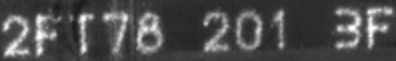

In [9]:
image1

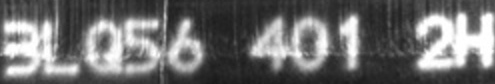

In [10]:
image2

In [11]:
pixel_values = my_processor(img_ls, return_tensors='pt').pixel_values
generated_ids = my_model.generate(pixel_values)
generated_text = my_processor.batch_decode(generated_ids, skip_special_tokens=True)
generated_text = [i_str.replace(' ', '') for i_str in generated_text]
generated_text

['2FT782013F', '3LQ564012H']

# TrOCR model architecture

In [12]:
# 將所有模型參數轉換為一個列表
params = list(my_model.named_parameters())  # len(params) == 480
print('The model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:4]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Encoder ====\n')

for p in params[4:164]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Decoder ====\n')

for p in params[164:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The model has 480 different named parameters.

==== Embedding Layer ====

encoder.embeddings.cls_token                             (1, 1, 768)
encoder.embeddings.position_embeddings                  (1, 577, 768)
encoder.embeddings.patch_embeddings.projection.weight   (768, 3, 16, 16)
encoder.embeddings.patch_embeddings.projection.bias           (768,)

==== Encoder ====

encoder.encoder.layer.0.attention.attention.query.weight   (768, 768)
encoder.encoder.layer.0.attention.attention.key.weight    (768, 768)
encoder.encoder.layer.0.attention.attention.value.weight   (768, 768)
encoder.encoder.layer.0.attention.output.dense.weight     (768, 768)
encoder.encoder.layer.0.attention.output.dense.bias           (768,)
encoder.encoder.layer.0.intermediate.dense.weight        (3072, 768)
encoder.encoder.layer.0.intermediate.dense.bias              (3072,)
encoder.encoder.layer.0.output.dense.weight              (768, 3072)
encoder.encoder.layer.0.output.dense.bias                     (768,)
en

# [reference1](https://huggingface.co/docs/transformers/model_doc/trocr)

# [reference2](https://arxiv.org/pdf/2109.10282.pdf)